In [18]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from src.embedding import Embedding
from src.environment import Rewards_env
from src.evaluations import evaluate, plot_eva
from src.regression import *
from src.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

# Plot setting

In [19]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['axes.labelsize'] = MEDIUM_SIZE # 15
rcParams['xtick.labelsize'] = SMALL_SIZE # 13
rcParams['ytick.labelsize'] = SMALL_SIZE # 13
rcParams['legend.fontsize'] = SMALL_SIZE # 13
rcParams['axes.titlesize'] = BIGGER_SIZE  # 15
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Computer Modern Roman']
# rcParams['text.usetex'] = True

# set color
# https://www.thinkingondata.com/something-about-viridis-library/
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

color_dict['Consensus'] = tab10.colors[0]
color_dict['Reference'] = tab10.colors[6]
color_dict['BPS-C'] = tab10.colors[14]
color_dict['BPS-NC'] = tab10.colors[12]
color_dict['UNI'] = tab10.colors[10]
color_dict['PPM'] = tab10.colors[11]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

color_dict['Bandit-0'] = viridis.colors[3]
color_dict['Bandit-1'] = viridis.colors[8]
color_dict['Bandit-2'] = viridis.colors[13]
color_dict['Bandit-3'] = viridis.colors[18]

color_dict['Unlabeled'] = tab10.colors[15]
color_dict['Random'] = tab10.colors[10]

bandit_color_dict = {}

bandit_color_dict['Bandit-0'] = viridis.colors[3]
bandit_color_dict['Bandit-1'] = viridis.colors[8]
bandit_color_dict['Bandit-2'] = viridis.colors[13]
bandit_color_dict['Bandit-3'] = viridis.colors[18]

# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')

folder_path = '../data/'
# plot_path = '../../notebooks/paper_plots/'
plot_path = './plots'
if not os.path.join(plot_path):
    os.mkdir(plot_path)
plot_path_supp = plot_path

# plot_path = '../../../paper/writing/wcb_icml2021/wcb2021_plot/'

In [20]:
plot_swarm_flag = True
plot_quant_flag = True
plot_scatter_flag = True
plot_tsne_flag = True
plot_hist_flag = True
gene_rec_flag = False

In [21]:
wcb_color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

wcb_color_dict['Consensus'] = tab10.colors[0]
wcb_color_dict['Reference'] = tab10.colors[6]
wcb_color_dict['Random'] = tab10.colors[10]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

wcb_color_dict['Bandit-0'] = viridis.colors[3]
wcb_color_dict['Bandit-1'] = viridis.colors[8]
wcb_color_dict['Bandit-2'] = viridis.colors[13]
wcb_color_dict['Bandit-3'] = viridis.colors[18]
wcb_color_dict['Unlabeled'] = tab10.colors[15]


# Read data

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
    - C.2 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on each round
    - D.2 on all data
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 
    - E.1 on each round
    - E.2 on all data

In [22]:
# read data
i = 1 # trial i
rec_size = 90
file_path = './sim_results/recs_{}_{}.csv'.format(i, rec_size)
df = pd.read_csv(file_path) # raw data
df[df['Round'] == 1]

,Unnamed: 0,RBS,RBS6,pred mean,pred std,ucb,lcb,Group,Round,AVERAGE
90,90,TTTAAGAGGAGGGTATACAT,GGAGGG,2.159033,0.677658,3.514349,0.803716,Bandit-0,1,3.011046
91,91,TTTAAGAGGAAGGTATACAT,GGAAGG,2.009056,0.687198,3.383453,0.634660,Bandit-0,1,2.601778
92,92,TTTAAGAGAGAGGTATACAT,GAGAGG,1.844082,0.765778,3.375639,0.312525,Bandit-0,1,2.601778
93,93,TTTAAGAGAAGGGTATACAT,GAAGGG,1.951458,0.704149,3.359755,0.543161,Bandit-0,1,2.430205
94,94,TTTAAGAGAGGGGTATACAT,GAGGGG,2.061791,0.642385,3.346560,0.777022,Bandit-0,1,2.686284
...,...,...,...,...,...,...,...,...,...,...
175,175,TTTAAGAAACGGGTATACAT,AACGGG,1.348862,0.735278,2.819417,-0.121694,Bandit-0,1,1.489568
176,176,TTTAAGAATAAGGTATACAT,ATAAGG,1.408819,0.705017,2.818853,-0.001216,Bandit-0,1,2.179175
177,177,TTTAAGAGCGGGATATACAT,GCGGGA,1.328376,0.741705,2.811786,-0.155034,Bandit-0,1,2.407345
178,178,TTTAAGAGGCAGGTATACAT,GGCAGG,1.385535,0.712745,2.811025,-0.039954,Bandit-0,1,2.601778


In [23]:
result_path = '../data/Results_Salis.csv'
result_df = pd.read_csv(result_path, header = 0)
result_df.sort_values(by = 'AVERAGE')[::-1][:5]

,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
385,385,NaN,NaN,10,TTTAAGAAGGAGGTATACAT,AGGAGG,3.954484,4.196468,4.117102,4.769181,4.590543,4.018769,4.359780,0.3
386,386,NaN,NaN,10,TTTAAGAGGGAGGTATACAT,GGGAGG,3.540180,4.349595,4.142404,4.063964,4.206067,3.685398,4.020691,0.3
21,21,NaN,NaN,10,TTTAAGAAGGGGGTATACAT,AGGGGG,3.658627,3.684215,3.824001,3.794949,3.717763,3.700905,3.959732,0.3
387,387,NaN,NaN,10,TTTAAGAGGAGGTTATACAT,GGAGGT,3.410581,3.321649,3.518620,3.927013,3.723947,3.949444,3.689223,0.3
6,6,NaN,NaN,10,TTTAAGAGGGGGGTATACAT,GGGGGG,3.611154,3.637786,3.523388,3.411811,3.492763,3.571987,3.620643,0.3


# G-rich exploitation

In [24]:
Grich_dict = {}
for group in ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2','Bandit-3']:
    Grich_dict[group] = 0
    seqs = np.asarray(df.loc[df['Group'] == group, 'RBS6'].values)
#     print(seqs)
    for rbs6 in seqs:
        if rbs6.count('G') >= 3:
            Grich_dict[group] += 1
    Grich_dict[group] /= float(len(seqs))
Grich_dict

{'Random': 0.15555555555555556,
 'Bandit-0': 0.8444444444444444,
 'Bandit-1': 0.8555555555555555,
 'Bandit-2': 0.7,
 'Bandit-3': 0.7666666666666667}

# Swarmplot

/home/v-mezhang/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning:

5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/v-mezhang/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning:

13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



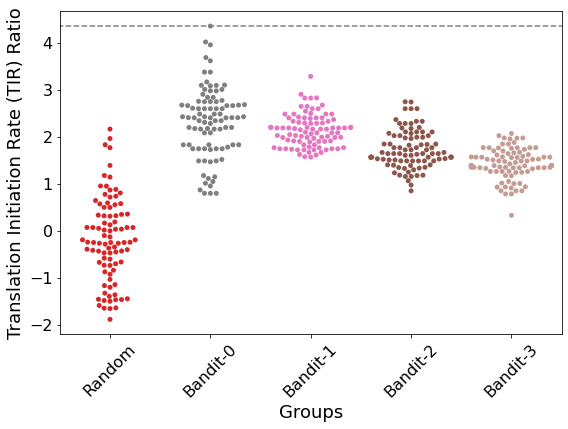

In [25]:
sns.set_palette(list(color_dict.values())[1:])
# sns.set_palette(list(wcb_color_dict.values())[1:])

if plot_swarm_flag:
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df, ax = axes, order=['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
#     sns.swarmplot(x = 'Group2', y = 'AVERAGE', data = df, ax = axes, order=['Reference', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])

    # y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
    y = result_df['AVERAGE'].max()
    # axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
    axes.plot([-1,9], [y,y], '--', color = 'grey')
    # axes.text(0, 1.06, 'BN')
    # axes.text(0, y + 0.05, 'SD')

    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
#     \n averaged over 6 technical replicates
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig(plot_path + 'swarmplot.pdf')

# Quantile plot

In [26]:

def quant_line(df, col = 'Group', title = 'Quantile of groups'):
    f, axes = plt.subplots(1, 1, figsize=(5, 6), sharex=False)
    quantile_levels = [0.9, 0.8, 0.7, 0.6, 0.5]
    used_groups = ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
    df_bandits = df.loc[df[col].isin(used_groups)]

    quant_dict = defaultdict(list)
    groups = df_bandits.groupby(col)
    

    for used_group in used_groups:
        quant_dict['max'].append(groups.get_group(used_group)['AVERAGE'].max())
    axes.plot(range(len(used_groups)), quant_dict['max'], marker = '.', linestyle = 'dashdot', markersize = 12, label = 'max', alpha = 0.8, color = 'orange')

    for quant in quantile_levels:
        for used_group in used_groups:
            quant_dict[quant].append(groups.get_group(used_group)['AVERAGE'].quantile(quant))
        axes.plot(range(len(used_groups)), quant_dict[quant], marker = '.', linestyle = 'dashdot', markersize = 12, label = str(quant) + ' Q', alpha = 0.8)
    print(quant_dict)
    # plt.plot(df_bandits.sort_values('AVERAGE',ascending=False).groupby(col).nth(4)['AVERAGE'], marker = '.', label = 'Top-5', alpha = 0.6)
    plt.legend(loc ='upper left', fontsize = 14) # , fontsize = 'small'
    axes.plot([0,5], [1,1], '--', color = 'grey')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
    plt.xticks(range(len(used_groups)), used_groups, rotation=45)
#     plt.title(title)
    plt.tight_layout()
    # plt.savefig(plot_path + 'quantplot.pdf')

defaultdict(<class 'list'>, {'max': [2.167316224851671, 4.359779818024226, 3.2891749354312845, 2.748157595199213, 2.073790921323316], 0.9: [0.890494599072945, 3.098531149305087, 2.6017781550681867, 2.28632694265379, 1.7804223892466176], 0.8: [0.5759501878365074, 2.84256891426542, 2.4073450367025915, 2.0835140680812576, 1.7009918876019487], 0.7: [0.31495884228630133, 2.669852761244669, 2.297665440192524, 1.8841605924185263, 1.5711096504615945], 0.6: [0.04480832351264916, 2.5331240554162937, 2.1909859782583827, 1.7710781979203505, 1.5156439300604494], 0.5: [-0.24071543556725175, 2.4092500254505884, 2.15975828837761, 1.6453488146396908, 1.3923899573656315]})


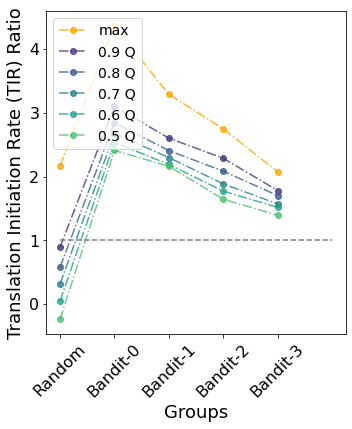

In [27]:
if plot_quant_flag:
    sns.set_palette('viridis') 
    quant_line(df, 'Group')
    

# TSNE plot

In [28]:
n_dim = 2

wds_kernel = WD_Shift_Kernel(l = 6, s=1)
distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)

Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True


In [29]:
distance.shape

(4138, 4138)

In [30]:

# dim reduction
tsne = TSNE(n_components = n_dim, metric = 'precomputed', random_state = 5)
tsne_distance = tsne.fit_transform(distance)

In [31]:
with open('../../data/idx_seq.pickle', 'rb') as handle:
    idx_seq_dict = pickle.load(handle)['idx_seq_dict']

group_dict = defaultdict(list)
group_TIR_dict = defaultdict(list)
group_RBS6_dict = defaultdict(list)
known_seq = set(df['RBS'])
size = 120

for idx in range(distance.shape[0]):
    seq = idx_seq_dict[idx]
    if seq in known_seq:
        group = df.loc[df['RBS'] == seq, 'Group'].values[0]
        TIR = df.loc[df['RBS'] == seq, 'AVERAGE'].values[0]
        RBS6 = df.loc[df['RBS'] == seq, 'RBS6'].values[0]
        # print(group)
        group_dict[group].append(idx)
        group_TIR_dict[group].append(TIR * size)
        group_RBS6_dict[group].append(RBS6)
        # idx_color_dict[idx] = color_dict[str(group)]
        # color_list.append(color_dict[str(group)])
    else:
        group_dict['Unlabeled'].append(idx)
        group_TIR_dict['Unlabeled'].append(0.2 * size)
        group_RBS6_dict['Unlabeled'].append(idx_seq_dict[idx])


/home/v-mezhang/.local/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning:

invalid value encountered in sqrt



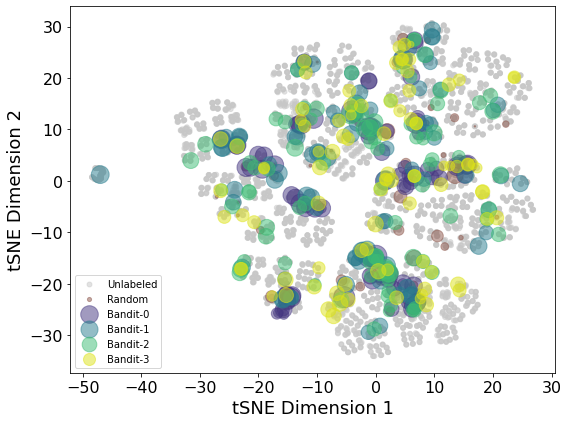

In [32]:
sns.set_palette(list(color_dict.values())[1:])

if plot_tsne_flag:
    rcParams['legend.fontsize'] = 10
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    groups = ['Unlabeled', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
#     groups = ['Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'Reference', 'Unlabeled']
    for group in groups:
        idxes = np.asarray(group_dict[group])
        
        alpha = 0.5
      
        plt.scatter(tsne_distance[idxes,0], tsne_distance[idxes,1], alpha = alpha, color = color_dict[group],  s = group_TIR_dict[group][:], label = group)
#         edgecolors = 'none',
        
#         plt.plot(-2.5, 25, 'o',
#                 ms=39 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
#         plt.plot(-7.5,0.5, 'o',
#                 ms=18 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
#         plt.plot(4.5,-7.5, 'o',
#                 ms=19 * 2, mec='b', alpha = 0.6, mfc='none', mew=1)
#         plt.annotate('G-Rich Clusters', xy=[-6, 25], xytext=(-120, 30),
#                     textcoords='offset points',
#                     color='b', size='small',
# #                     arrowprops=dict(
# #                         arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
# #                         facecolor='b', shrinkB=39 * 1.2, alpha = 0.6)
#                     )
        plt.legend(loc = 'lower left')
        plt.xlabel('tSNE Dimension 1')
        plt.ylabel('tSNE Dimension 2')
#         plt.title('TSNE for RBS design space')
        plt.tight_layout()
        # plt.savefig(plot_path +'tsneplot.pdf')
        
rcParams['legend.fontsize'] = 13

# Histogram

In [33]:
def hist(df, title = 'Hist'):
    f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
    df = df.append({'Group': 'Bandit-2', 'AVERAGE' : -0.1}, ignore_index=True) # for kde range
    df_bandits = df.loc[df['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])]
    sns.histplot(data = df_bandits, x = 'AVERAGE', binwidth = 0.1, 
    # binrange = [0, 1.4], 
    hue = 'Group', kde=True, 
                #  kde_kws ={'clip': [0,1.4]}, 
                 alpha = 0.5)
    # df_random = df[df['Group2'] == 'Random']
    # sns.histplot(data = df_random, x = 'AVERAGE', hue = 'Group2', kde=True, color = color_dict['Random'])
    axes.set(xlabel='Translation Initiation Rate (TIR) Ratio')
#     plt.title(title)
    # plt.xlim(0,1.4)
    plt.tight_layout()
    plt.savefig(plot_path +'histogram.pdf')
    print('mean:')
    print(df_bandits.groupby('Group').mean())
    print('0.9 quantile')
    print(df_bandits.groupby('Group').quantile(0.9))

mean:
          Unnamed: 0  pred mean  pred std       ucb       lcb  Round   AVERAGE
Group                                                                         
Bandit-0       134.5   1.594791  0.715439  3.025668  0.163914    1.0  2.323215
Bandit-1       224.5   1.990461  0.523323  1.990461  1.990461    2.0  2.142367
Bandit-2       314.5   1.620872  0.495878  1.620872  1.620872    3.0  1.711884
Bandit-3       404.5   1.457575  0.458147  1.457575  1.457575    4.0  1.429299
0.9 quantile
          Unnamed: 0  pred mean  pred std       ucb       lcb  Round   AVERAGE
Group                                                                         
Bandit-0       170.1   1.879861  0.763883  3.287055  0.543199    1.0  3.098531
Bandit-1       260.1   2.275068  0.600159  2.275068  2.275068    2.0  2.601778
Bandit-2       350.1   1.769390  0.602051  1.769390  1.769390    3.0  2.286236
Bandit-3       440.1   1.579604  0.555647  1.579604  1.579604    4.0  1.780422


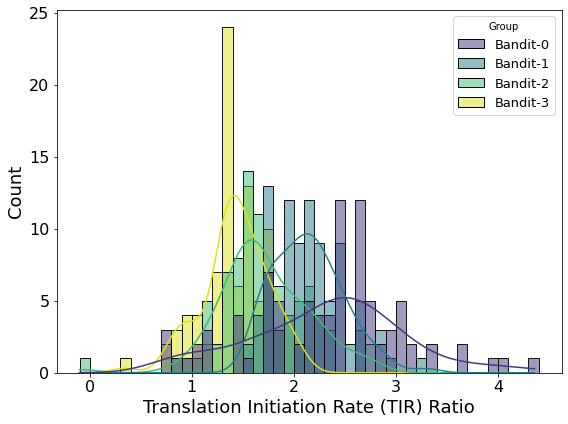

In [34]:
if plot_hist_flag:
#     sns.set_palette('viridis') 
    sns.set_palette(list(bandit_color_dict.values())) 
    hist(df, 'Histogram')

# Scatterplot

In [35]:
# copy from the pipeline for recommending round 2 seq
from src.batch_ucb import *
from src.regression import *
from scipy.stats import spearmanr

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

sns.set_palette('tab10') 

In [36]:
def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
                    eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
                    eva_on='seqs', title = 'Prediction',
                    kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True, kernel_over_all_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression(random_state = 0)

    return gpr_train_samples
    # gpr_train_samples.scatter_plot(title = title)

In [37]:
def scatter_plot(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        fig, axes = plt.subplots(2,2, figsize = (12,12))
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            if i < 2:
                row = 0
            else:
                row = 1

            axes[row, i % 2].scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes[row, i % 2].scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes[row, i % 2].set_xlabel('True TIR')
            axes[row, i % 2].set_ylabel('Predict TIR')
            axes[row, i % 2].legend()
            axes[row, i % 2].plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes[row, i % 2].set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
#         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path + 'scatter_' + valid_path(plot_title) + '.pdf')

In [38]:
def scatter_plot_single(predictor_list, title, plot_title = 'Prediction', save_to = ''):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        sns.set_palette('tab10') 
        
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            fig, axes = plt.subplots(1,1, figsize = (6,6))

            axes.scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes.scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes.set_xlabel('True TIR')
            axes.set_ylabel('Predict TIR')
            axes.legend()
            axes.plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes.set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#           fig.suptitle(plot_title, size = 16, y = 0.98)
            fig.tight_layout()
    #       fig.subplots_adjust(top=0.85)
            fig.savefig(save_to + 'scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')

In [39]:
def generate_predictors(df, kernel, embedding, kernel_norm_flag = True, centering_flag = True, unit_norm_flag = True, kernel_over_all_flag = True):
    predictors = []
    for i in range(1,4):
        title = 'Train < ' + str(i)+ ' and Test ' + str(i)
        predictor = run_regression(df, kernel, embedding, train_idx = df['Round'] < i, test_idx = df['Round'] == i, title = title, centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
        predictors.append(predictor)

    predictor = run_regression(df, kernel, embedding, title = 'Train and Test on All Rounds', centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
    predictors.append(predictor)
    return predictors
    

In [40]:
result_path = '../data/Results_Salis.csv'
data_df = pd.read_csv(result_path, header = 0)
data_df

,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,NaN,NaN,10,TTTAAGAGGGGGCTATACAT,GGGGGC,2.066753,2.116192,2.066186,2.170284,2.279228,2.455489,2.100461,0.3
1,1,NaN,NaN,10,TTTAAGAGGGGGTTATACAT,GGGGGT,3.407296,2.861010,2.836067,2.923099,4.096881,3.422200,3.289175,0.3
2,2,NaN,NaN,10,TTTAAGAAGGAGATATACAT,AGGAGA,2.671651,3.021088,3.012814,2.663747,2.792270,2.707390,2.649098,0.3
3,3,NaN,NaN,10,TTTAAGAGGCTATTATACAT,GGCTAT,0.498333,0.766167,0.377015,0.440593,0.586706,0.576082,0.416449,0.3
4,4,NaN,NaN,10,TTTAAGAGGCGACTATACAT,GGCGAC,-1.212809,-0.237171,-0.646353,-1.123985,-1.374760,-0.458668,-1.046584,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,NaN,NaN,10,TTTAAGAATCTCCTATACAT,ATCTCC,-3.374268,-3.082718,-2.829038,-3.488157,-3.195335,-3.365894,-3.195766,0.3
4092,4092,NaN,NaN,10,TTTAAGACTCTCCTATACAT,CTCTCC,-3.311788,-3.444556,-3.251878,-3.109190,-3.446362,-3.166488,-3.195766,0.3
4093,4093,NaN,NaN,10,TTTAAGAGTCTCCTATACAT,GTCTCC,-2.991230,-3.016737,-2.823481,-3.101023,-3.242048,-3.086655,-3.195766,0.3
4094,4094,NaN,NaN,10,TTTAAGATCTGCCTATACAT,TCTGCC,-3.046706,-3.334268,-3.027667,-3.404999,-3.116963,-3.716938,-3.284462,0.3


In [41]:
df_merge = df[['RBS', 'RBS6', 'Group', 'Round']].merge(data_df[['RBS', 'Rep1', 'Rep2','Rep3','Rep4','Rep5','Rep6','AVERAGE','STD']])

In [42]:
if plot_scatter_flag:
    centering_flag = True
    unit_norm_flag = True
    df['STD'] = None
    df_abc1_TT_predictors = generate_predictors(df_merge, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (540, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (1080, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (1620, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
gp_reg pred
finish reg
X train shape:  (2160, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_T

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7fd909ad2598>
Train:  0.04558399462178181
Test:  1.0267604773549732
<function r2_score at 0x7fd909ad2bf8>
Train:  0.942695802777824
Test:  -0.876432228421592
spearman cor:
Train:  SpearmanrResult(correlation=0.9691916226389253, pvalue=0.0)
Test:  0.30842590895831756   0.00310099233767216
Test pred fit:  [0.0023863  1.48860064]
Test ave fit:  [0.02742185 1.10294277]
coverage rate: 
Train:  1.0
Test:  0.8555555555555555
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7fd909ad2598>
Train:  0.05304129289499791
Test:  0.09013356513318786
<function r2_score at 0x7fd909ad2bf8>
Train:  0.976103324521752
Test:  0.22428524622600754
spearman cor:
Train:  SpearmanrResult(correlation=0.9883108796797024, pvalue=0.0)
Test:  0.5043666328317928   4.01033166266518

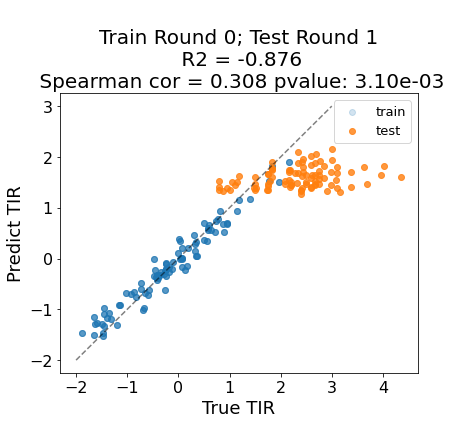

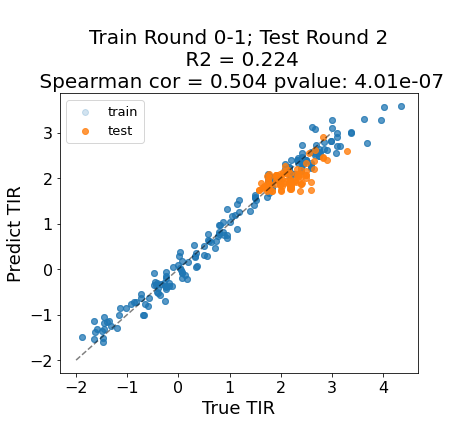

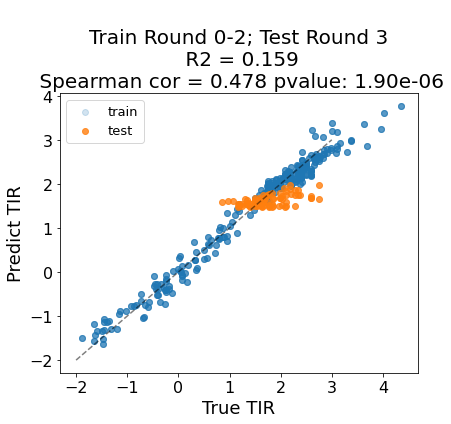

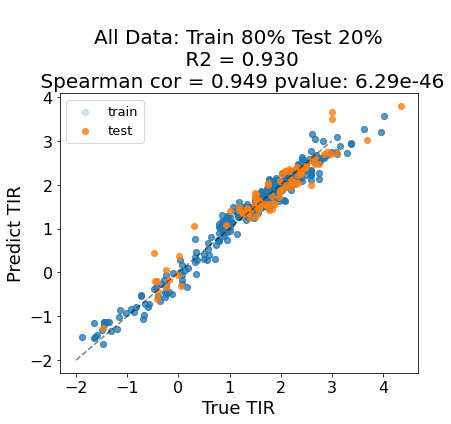

In [43]:
sns.set_palette('tab10') 
if plot_scatter_flag:
    scatter_plot_single(df_abc1_TT_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 TT', save_to = plot_path_supp)

In [44]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False

    df_abc1_FF_predictors = generate_predictors(df_merge, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (540, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (1080, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (1620, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (2160, 20)
X test shape:  (90, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_Fal

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7fd909ad2598>
Train:  0.11501687584731463
Test:  1.6902894951964638
<function r2_score at 0x7fd909ad2bf8>
Train:  0.8554108784866428
Test:  -2.0890492516031838
spearman cor:
Train:  SpearmanrResult(correlation=0.9448752474858911, pvalue=4.9545725344072184e-263)
Test:  0.1986255606687403   0.06055471833781508
Test pred fit:  [0.00146275 1.17704972]
Test ave fit:  [0.02742185 1.10294277]
coverage rate: 
Train:  0.9666666666666667
Test:  0.3888888888888889
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7fd909ad2598>
Train:  0.10958740175678078
Test:  0.15098172550741404
<function r2_score at 0x7fd909ad2bf8>
Train:  0.9506276255092352
Test:  -0.2993910964610471
spearman cor:
Train:  SpearmanrResult(correlation=0.9779195087825289, pvalue=0.0)
Test:  

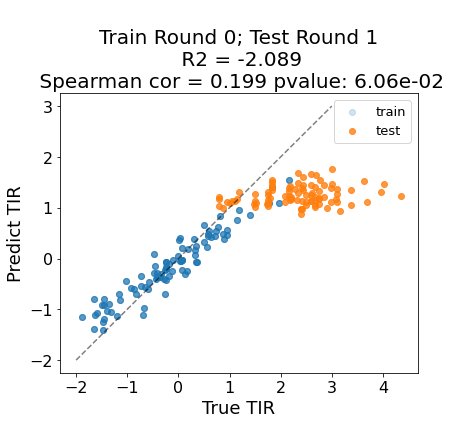

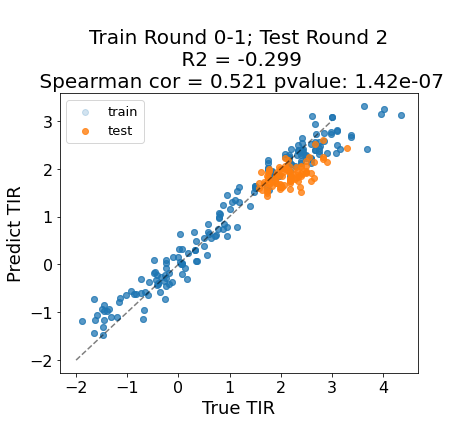

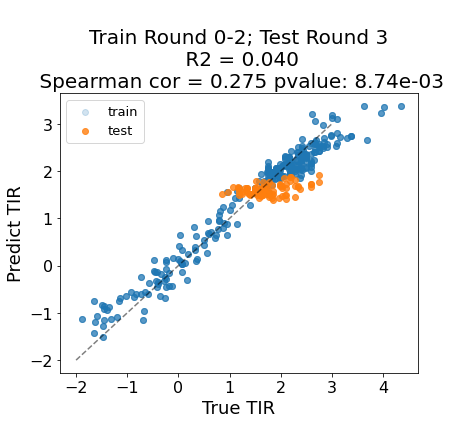

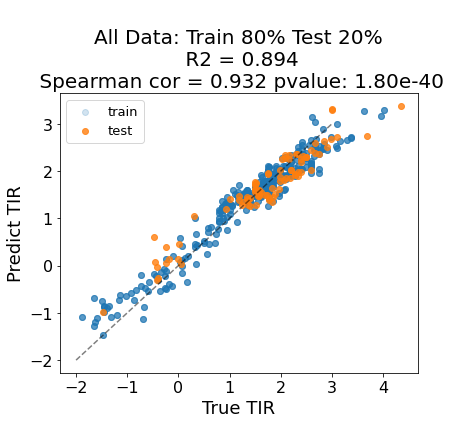

In [45]:
if plot_scatter_flag:
    
    scatter_plot_single(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF', save_to=plot_path)